## Imports

In [55]:
import sys
sys.path.append("/home/roman/study/la/dim-red")

In [56]:
from dimred.models import PCAModel, SVDModel, KMeansModel, AutoEncoderModel
from dimred.metrics import get_metrics

In [57]:
import glob
import os
import pandas as pd
from pathlib import Path
from shutil import copyfile
import time
from tqdm import tqdm
import cv2 
from math import ceil
import matplotlib.pyplot as plt
import numpy as np

## Utils

In [94]:
def get_ax(ax, col, row):
    if type(ax) is np.ndarray:
        curr_row_ax = ax[col]
        if type(curr_row_ax) is np.ndarray:
            return curr_row_ax[row]
        return curr_row_ax
    return ax

def plot_images(images, labels=None, cols=5, col_width=4, row_width=4, show_axis=False):
    rows = ceil(len(images) / cols)
    fig, ax = plt.subplots(rows, cols, figsize=(20, rows * row_width))

    curr_row = 0
    curr_col = 0
    for i in range(len(images)):
        row = i % cols
        col = i // cols
        if rows == 1 and cols > 1:
            col = row
        curr_ax = get_ax(ax, col, row)
        curr_ax.imshow(images[i])
        if labels is not None and i < len(labels):
            curr_ax.set_title(labels[i], fontdict=dict(fontsize=16))
        if not show_axis:
            curr_ax.get_xaxis().set_visible(False)
            curr_ax.get_yaxis().set_visible(False)
        curr_col += 1
        if curr_col == cols:
            curr_col = 0
            curr_row += 1
    return fig

In [59]:
def get_images_subset(save_dir, glob_path, start, end):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        image_paths = sorted(glob.glob(glob_path))[start:end]
        for image_path in image_paths:
            file_name = image_path.rsplit("/", 1)[1]
            copyfile(image_path, os.path.join(save_dir, file_name))

In [60]:
def read_img(path: str): 
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [61]:
def get_image_paths(images_directory, max_num=None):
    for index, image_path in enumerate(sorted(glob.glob(os.path.join(images_directory, "*.jpg")))):
        if index == max_num:
            return
        yield image_path

In [108]:
def batch(iterable, n = 1):
    current_batch = []
    for item in iterable:
        current_batch.append(item)
        if len(current_batch) == n:
            yield current_batch
            current_batch = []
    if current_batch:
        yield current_batch

## Prepare Data

Dataset to download: https://www.kaggle.com/adityajn105/flickr8k

In [62]:
original_image_path_directory = "original_images"
training_image_path_directory = "training_images"
glob_pattern = "/datasets/flickr8k/Images/*.jpg"

get_images_subset(original_image_path_directory, glob_pattern, 0, 400)
get_images_subset(training_image_path_directory, glob_pattern, 400, 1000)

num_of_images = len(sorted(glob.glob(os.path.join(original_image_path_directory, "*.jpg"))))

## Experiment Definition

In [73]:
class Experiment:
    def __init__(self, model, experiment_name, experiment_dir="experiments"):
        self.model = model
        self.experiment_name = experiment_name
        self.experiment_dir = experiment_dir
        
        self._rows = list()
        os.makedirs(os.path.join(experiment_dir, experiment_name), exist_ok=True)
        
    def process_image_from_path(self, image_path):
        image = read_img(image_path)
        save_image_path = os.path.join(self.experiment_dir, self.experiment_name, os.path.basename(image_path))
        metrics = get_metrics(compression_model=self.model, original_image=image)
        self._rows.append(metrics)
        
        output_image = self.model.decompress(self.model.compress(image))
        cv2.imwrite(save_image_path, cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR))
        
    def save_report(self):
        report = pd.DataFrame(self._rows)
        report["experiment_name"] = self.experiment_name
        report["model_name"] = type(self.model).__name__
        report.to_csv(os.path.join(self.experiment_dir, self.experiment_name, "report.csv"), index=False)
    
    def get_processed_image(self, index):
        image_paths = sorted(glob.glob(os.path.join(self.experiment_dir, self.experiment_name, "*.jpg")))
        return read_img(image_paths[index])
    
    def get_report(self):
        return pd.read_csv(os.path.join(self.experiment_dir, self.experiment_name, "report.csv"))

## Compare compression methods

In [74]:
experiments = [
    Experiment(model=KMeansModel.from_config("kmeans/config/kmeans_w4_2000.yaml"), experiment_name="kmeans_w4_2000"),
    Experiment(model=PCAModel(num_components=0.1), experiment_name="pca_0.1_components"),
    Experiment(model=SVDModel(num_components=0.1), experiment_name="svd_0.1_components"),
    Experiment(model=AutoEncoderModel.from_config("autoencoder/config/autoencoder.yaml"), experiment_name="autoencoder"),
]

In [70]:
# for experiment in experiments:
#     pbar = tqdm(total=num_of_images, desc=f"Experimet: {experiment.experiment_name}")
#     for image_path in get_image_paths(original_image_path_directory):
#         experiment.process_image_from_path(image_path)
#         pbar.update()
#     experiment.save_report()

## Generate Report

In [75]:
experiments_summary = pd.concat([experiment.get_report() for experiment in experiments])

In [76]:
summary_table = experiments_summary.groupby("model_name").mean()[["compression_ratio", "ssim", "vif-p", "psnr", "psnr-b", "mse"]]
summary_table

compression_ratio      ssim     vif-p       psnr     psnr-b  \
model_name                                                                      
AutoEncoderModel           0.664269  0.707014  0.263632  22.409260  22.743971   
KMeansModel                0.126334  0.824982  0.355669  26.220114  25.837619   
PCAModel                   0.454587  0.773673  0.322976  26.414440  26.296478   
SVDModel                   0.357592  0.728347  0.273082  25.208544  25.084683   

                         mse  
model_name                    
AutoEncoderModel  466.531951  
KMeansModel       199.469913  
PCAModel          207.819514  
SVDModel          265.317252

In [89]:
summary_table.to_csv("summary.csv", index=False)

## Generate Visuals

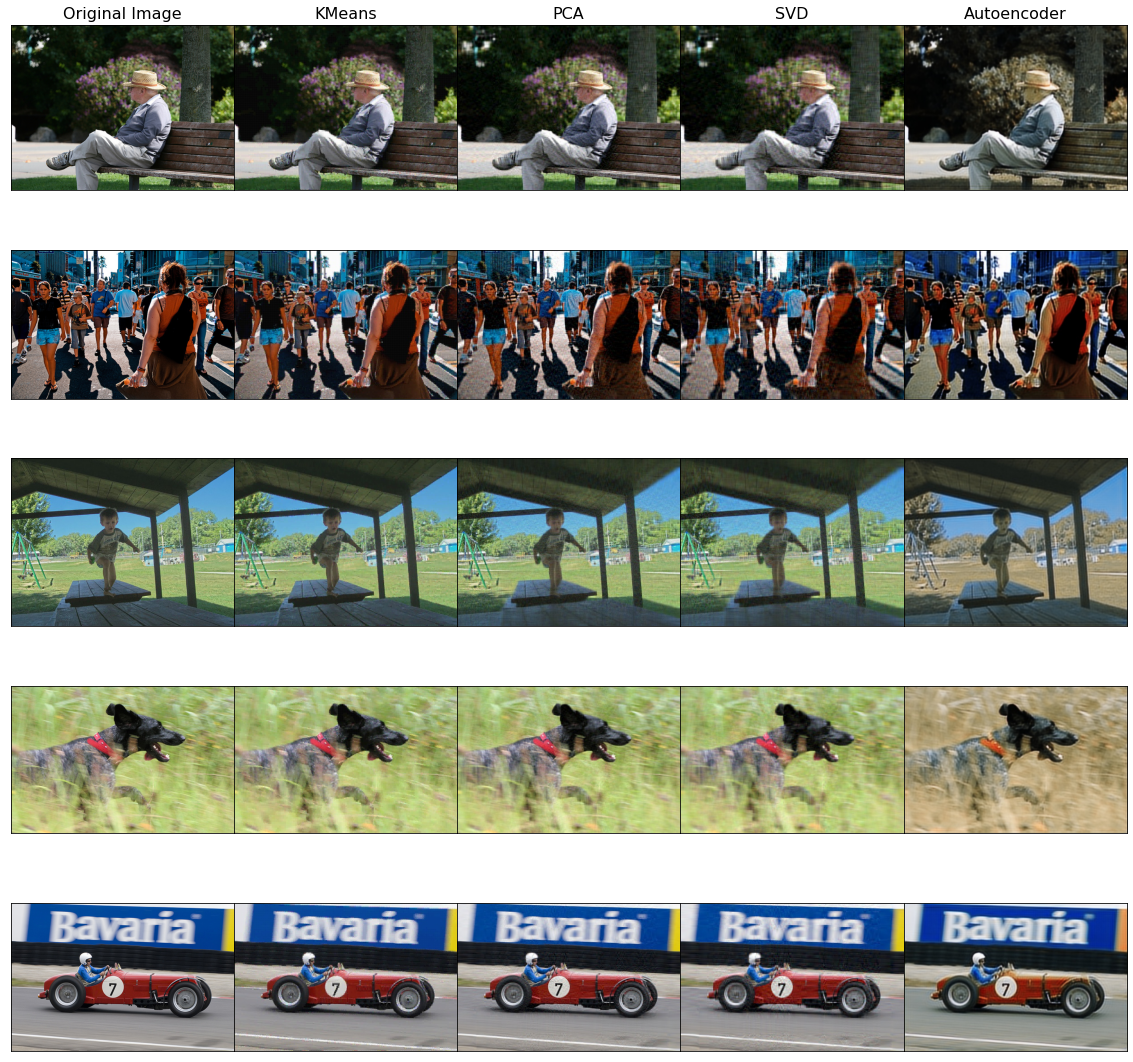

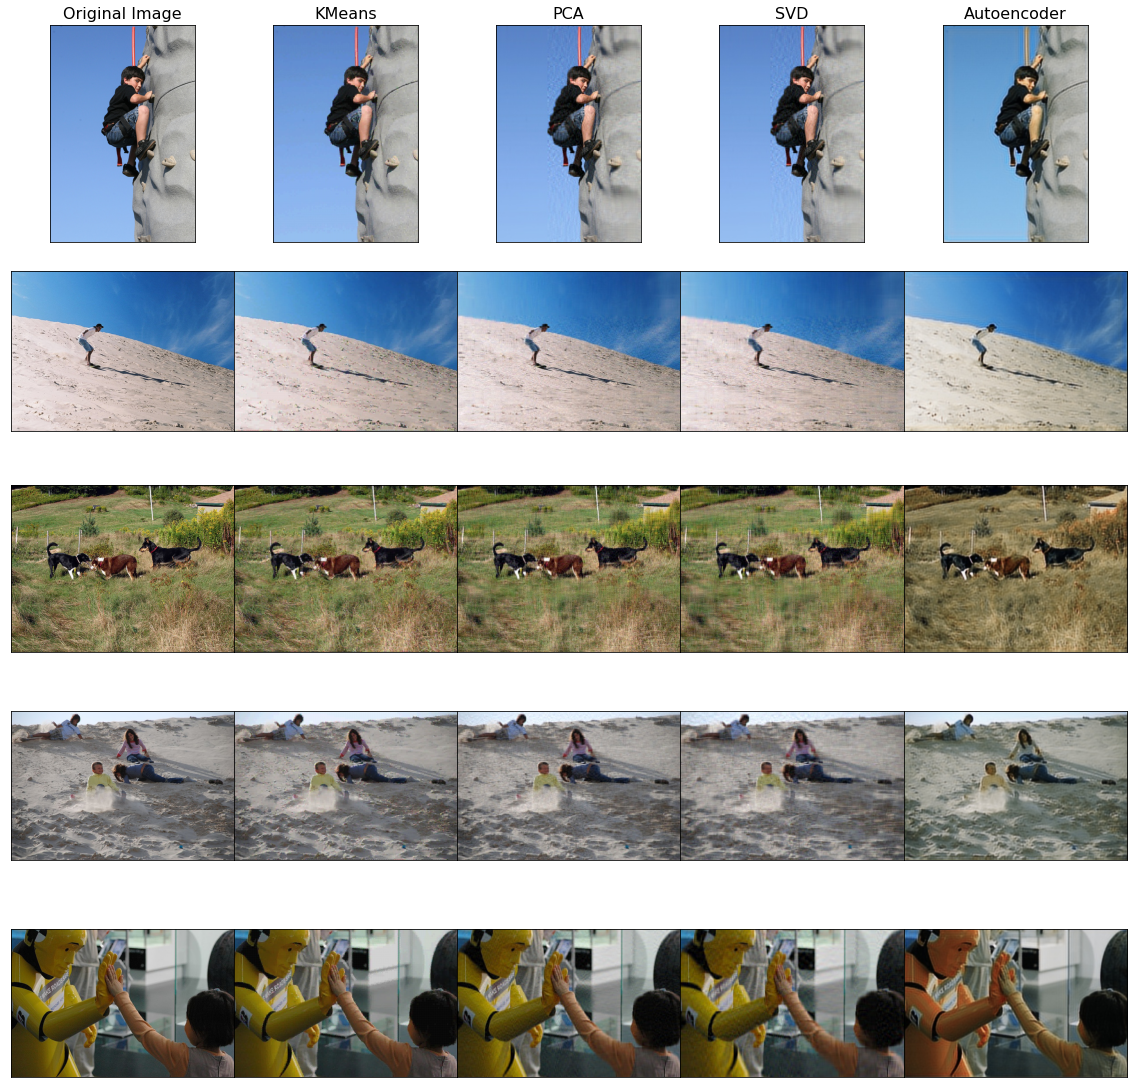

In [107]:
image_num = 5

labels = ["Original Image", "KMeans", "PCA", "SVD", "Autoencoder"]
all_images = list(get_image_paths(original_image_path_directory, 15))


for subset_index, images_subset in enumerate(batch(all_images, 5)):
    images = list()
    for image_index, image_path in enumerate(images_subset):
        images.append(read_img(image_path))
        for experiment, label_name in zip(experiments, labels):
            images.append(experiment.get_processed_image(image_index + subset_index * 5))
    fig = plot_images(images, labels, cols=len(experiments)+1)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.savefig(f"comparison_{subset_index}.png", dpi=fig.dpi, bbox_inches='tight', pad_inches=0)